In [1]:
from keras.applications import vgg16

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224 
# pre trained weights : create my model
model = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [3]:
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [4]:
def layeradding(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
num_classes = 2

FC_Head = layeradding(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/validation/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 292 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [7]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("myvgg16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 292
nb_validation_samples = 48

# We only train 5 EPOCHS 
epochs = 5
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
58/58 [==============================] - 1539s 27s/step - loss: 0.7938 - accuracy: 0.7245 - val_loss: 0.1386 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.13863, saving model to myvgg16.h5
Epoch 2/5
58/58 [==============================] - 2128s 37s/step - loss: 0.3823 - accuracy: 0.8700 - val_loss: 0.0561 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.13863 to 0.05608, saving model to myvgg16.h5
Epoch 3/5
58/58 [==============================] - 1612s 28s/step - loss: 0.2743 - accuracy: 0.8969 - val_loss: 0.0083 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.05608 to 0.00833, saving model to myvgg16.h5
Epoch 4/5
58/58 [==============================] - 1501s 26s/step - loss: 0.1950 - accuracy: 0.9271 - val_loss: 1.0074e-04 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00833 to 0.00010, saving model to myvgg16.h5
Epoch 5/5
58/58 [==============================] - 1414s 24s/step - loss: 0.1414 - accuracy: 0.9

In [8]:
from keras.models import load_model
classifier = load_model('myvgg16.h5')

In [15]:
import cv2
import numpy as np
myimage_dict = {"[0]": "shruti", 
                "[1]": "yash"}
myimage_dict_n = {"n0": "shruti", 
                  "n1": "yash"}
def draw_test(name, pred, im):
    my = myimage_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, my, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)
# cap = cv2.VideoCapture('https://192.168.43.123:8080/video')
#cap = cv2.VideoCapture(0)
# ret , photo = cap.read()
photo = cv2.imread('test.jpg')
cv2.imshow('Image capturing',photo)
input_im = cv2.resize(photo, (224, 224))
input_im = input_im / 255.
input_im = input_im.reshape(1,224,224,3)
# Get Prediction
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
# Show image with predicted class
draw_test("Prediction", res, photo) 
cv2.waitKey(0)
cv2.destroyAllWindows()
#cap.release()

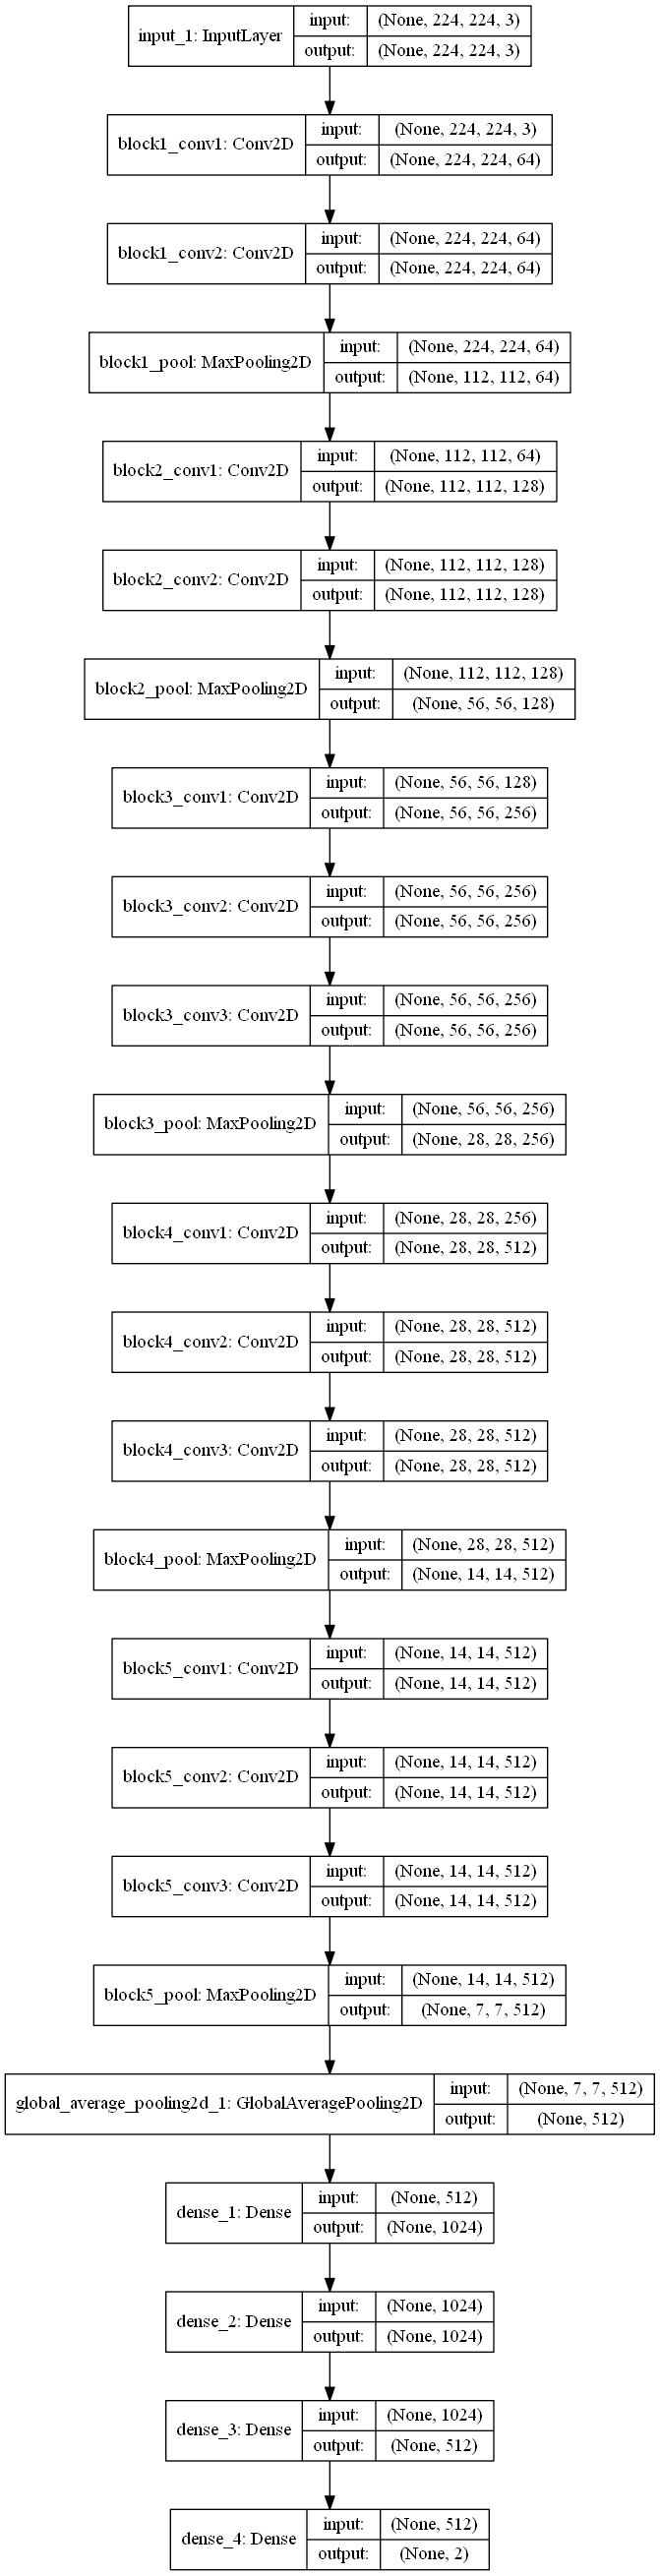

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='model_plot_vgg16.png', show_shapes=True, show_layer_names=True)

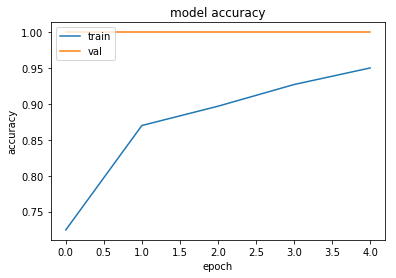

In [11]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

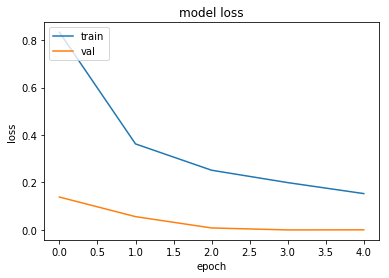

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()